In [37]:
import tensorflow as tf
from tensorflow import keras
import imageio
from tensorflow.keras import layers
from IPython import display
import tensorflow_datasets as tfds

In [38]:
BUFFER_SIZE = 400
BATCH_SIZE = 256
EPOCHS = 50
noise_dim = 100
num_gen = 4

In [39]:
data = tfds.load('mnist')

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [40]:
for i in data['train']:
  print(type(i), i.keys())
  break


<class 'dict'> dict_keys(['image', 'label'])


In [41]:
def preprocess(img_dict):
  img = tf.cast(img_dict['image'], tf.float32)
  img = img/127.5 -1
  return img

In [42]:
train_dataset = data['train'].map(preprocess).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [43]:
def make_gen():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, input_shape =(100, ), use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((7,7,256)))
  print(model.output_shape)
  model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides =(1,1) , padding = 'same',use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  print(model.output_shape)
  model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides =(1,1) , padding = 'same',use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  print(model.output_shape)
  model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides= (2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  print(model.output_shape)
  model.add(layers.Conv2DTranspose(1, kernel_size=(5,5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  print(model.output_shape)  
  return model


In [44]:
noise= tf.random.normal([1, 100])

(None, 7, 7, 256)
(None, 7, 7, 128)
(None, 7, 7, 128)
(None, 14, 14, 64)
(None, 28, 28, 1)


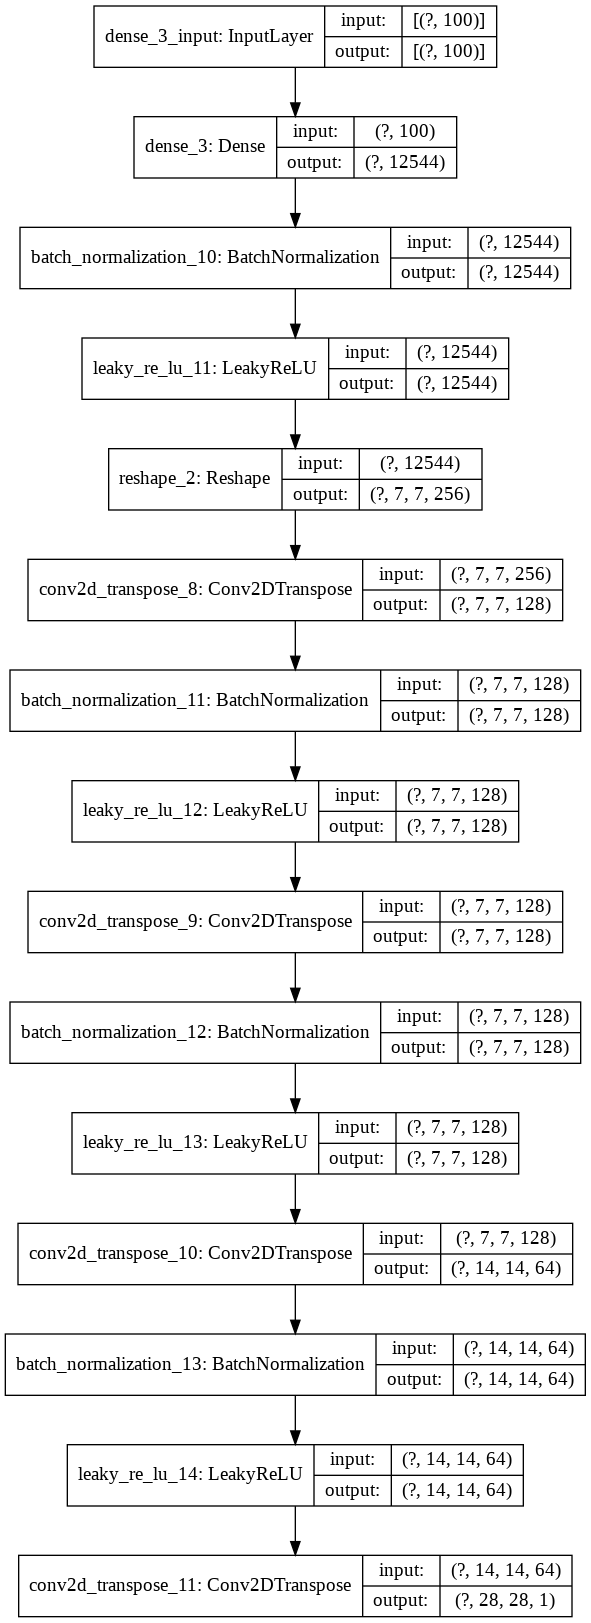

In [45]:
G = make_gen()
tf.keras.utils.plot_model(G, show_shapes=True)

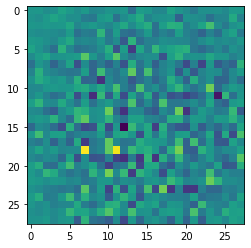

In [46]:
img = G(noise)
import matplotlib.pyplot as plt
plt.imshow(img[0, :, :, 0])

In [47]:
def make_disc():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, kernel_size=(5,5), strides=(2,2), padding='same',  input_shape=[28,28,1]))
  
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  print(model.output_shape)
  model.add(layers.Conv2D(128, kernel_size=(5,5), strides=(2,2), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  print(model.output_shape)
  model.add(layers.Conv2D(128, kernel_size=(5,5), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  print(model.output_shape)
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  print(model.output_shape)
  return model

(None, 14, 14, 64)
(None, 7, 7, 128)
(None, 7, 7, 128)
(None, 1)


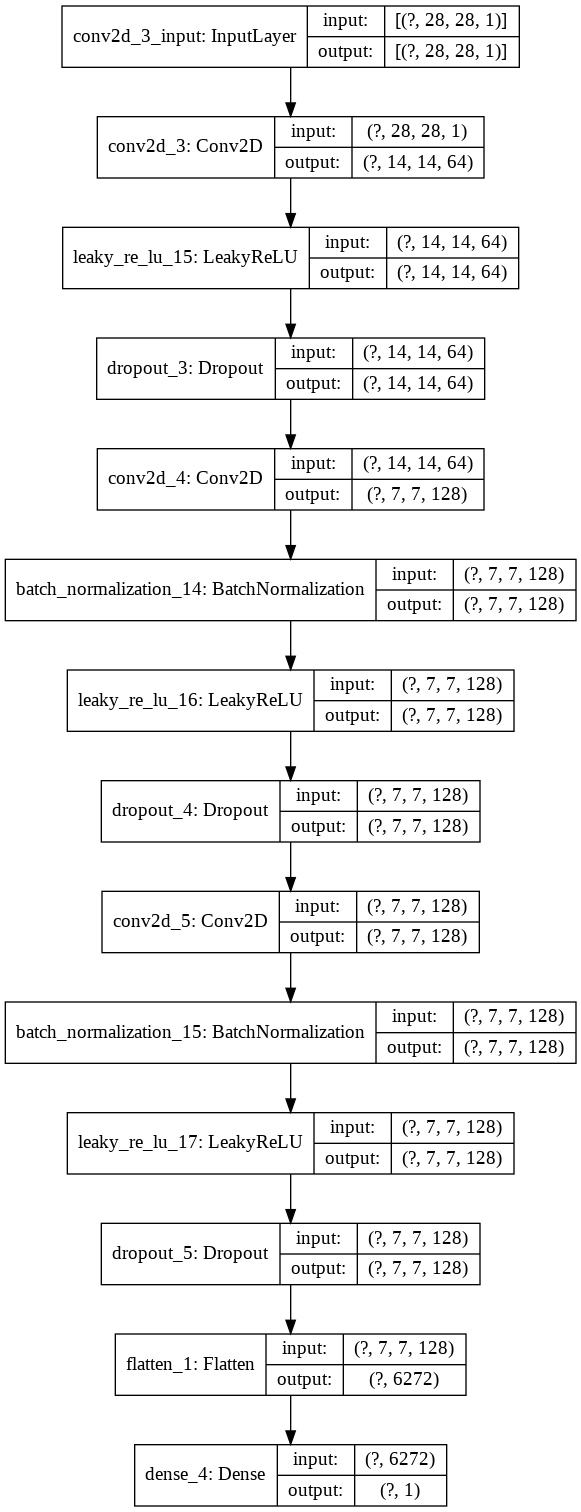

In [48]:
D = make_disc()
tf.keras.utils.plot_model(D, show_shapes=True)

In [49]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [50]:
def disc_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

def gen_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

    


In [51]:
G_opt = tf.keras.optimizers.Adam(1e-4)
D_opt = tf.keras.optimizers.Adam(1e-4)


In [52]:

seed = tf.random.normal([num_gen, noise_dim])

In [53]:
@tf.function
def train_step(x_batch):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as Gtape,  tf.GradientTape() as Dtape:
    gen_x = G(noise, training=True)
    real_output = D(x_batch,training=True)
    fake_output = D(gen_x, training =True)
    G_loss = gen_loss(fake_output)
    D_loss = disc_loss(real_output, fake_output)

  G_grad = Gtape.gradient(G_loss, G.trainable_variables)
  D_grad = Dtape.gradient(D_loss, D.trainable_variables)

  G_opt.apply_gradients(zip(G_grad, G.trainable_variables))
  D_opt.apply_gradients(zip(D_grad, D.trainable_variables))


In [54]:
import time
import matplotlib.pyplot as plt
def generate_images(model, epoch, test_input):
  pred = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(pred.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(pred[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.show()


def train(train_dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for x_batch in train_dataset:
      train_step(x_batch)
    print(f' {epoch+1} : {time.time()-start}')
  display.clear_output(wait=True)
  generate_images(G,epochs,seed)


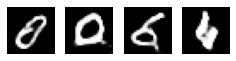

In [55]:
train(train_dataset, EPOCHS)

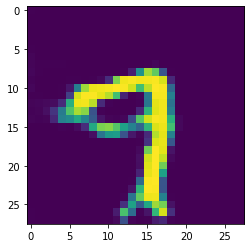

In [56]:
plt.imshow(G(tf.random.normal([1, 100]))[0, :, :, 0])